# Heterogeneous multiple-network poroelastic footing problem

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

### Problem data

In [ ]:
T = 0.05             # final simulation time
mu = Constant(1.0)   # mu fixed as reference parameter (keep it = 1)
lam = Constant(0.4)  # lam can be arbitrarly large (nearly incompressible case)
a_0 = Constant(0.0)  # a_0 can be equal to 0
b_0 = Constant(0.0)  # b_0 < a_0 and b_0 < c_0 (physical constraints)
c_0 = Constant(0.0)  # c_0 can be equal to 0
kappa = Expression('near(x[1], 0.5, 0.1) ? 0.1 : 1.0', degree=0)
#kappa = Constant(0.2) # strictly positive
#theta = Expression('near(x[0], 0.0, 0.5) ? 0.1 : 0.01', degree=0)
#theta = Expression('near(x[0], 0.5, 0.2) & near(x[1], 0.5, 0.2) ? 0.1 : 0.005', degree=0)
theta = Constant(0.5)# strictly positive
alpha = Constant(1.0) # strictly positive and smaller or equal to 1
beta = Constant(0.6)  # strictly positive and smaller or equal to 1

In [ ]:
# 0. method specific pre-computations
deg = 2
gamma = 9.1*deg**2
delta = 3.1/deg
#t_n = Expression(('0.0', '120.0*t*x[0]*(x[0]-1)'), t=0.0, degree=2)
t_n = Expression(('0.0', '10*x[0]*(x[0]-1)'), t=0.0, degree=2)
dt = 0.0025

# 1. mesh generation and boundary conditions
mesh = UnitSquareMesh(48, 48, 'crossed')
boundary_markers = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1, 0)

class top_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1)

class bottom_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0)

class other_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0) or near(x[0], 1)

class freeflow_boundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.5, 0.1) 

top = top_boundary()
top.mark(boundary_markers, 1)
bottom = bottom_boundary()
bottom.mark(boundary_markers, 2)
other = other_boundary()
other.mark(boundary_markers, 3)
fflow = freeflow_boundary()
fflow.mark(boundary_markers, 4)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# 2. definition of the lowest-order Taylor-Hood finite element pair
U = VectorElement('DG', mesh.ufl_cell(), deg)
Q = FiniteElement('DG', mesh.ufl_cell(), deg)
P = FiniteElement('DG', mesh.ufl_cell(), deg)
X = FunctionSpace(mesh, MixedElement([U, Q, P, P]))

# 3a. assembling: def functions and operators 
u, phi, p, tt = TrialFunctions(X)
v, psi, q, rr = TestFunctions(X)
x_old = Function(X)
u_old, phi_old, p_old, tt_old = split(x_old)
    
n = FacetNormal(mesh)
h = CellDiameter(mesh)
h_avg = (h('+') + h('-'))/2
kappa_avg = (kappa('+') + kappa('-'))/2
theta_avg = (theta('+') + theta('-'))/2

# 3b. assembling : def forms
a1 = (2.0*inner(sym(grad(u)), sym(grad(v))) + phi*div(v) - div(u)*psi)*dx  \
   - 2.0*inner(dot(avg(sym(grad(u))), n('+')), jump(v))*dS \
   - 2.0*inner(jump(u), dot(avg(sym(grad(v))), n('+')))*dS \
   - 2.0*inner(dot(sym(grad(u)), n), v)*ds(2) \
   - 2.0*inner(u, dot(sym(grad(v)), n))*ds(2) \
   - 2.0*inner(dot(sym(grad(u)), n), n)*inner(v, n)*(ds(3)+ds(4)) \
   - 2.0*inner(n, dot(sym(grad(v)), n))*inner(u, n)*(ds(3)+ds(4)) \
   + 2.0*gamma/h_avg*inner(jump(u), jump(v))*dS \
   + 2.0*gamma/h*inner(u, v)*ds(2) \
   + 2.0*gamma/h*inner(u, n)*inner(v, n)*(ds(3)+ds(4)) \
   + inner(jump(u, n), avg(psi))*dS - inner(jump(v, n), avg(phi))*dS \
   + inner(u, n)*psi*(ds(2)+ds(3)+ds(4)) - inner(v, n)*phi*(ds(2)+ds(3)+ds(4)) \
   + delta*h_avg*jump(phi)*jump(psi)*dS 

a2 = (1.0/lam)*(phi+alpha*p+beta*tt)*(psi+alpha*q+beta*rr)*dx \
   + (b_0*(p-tt)*(q-rr) + (c_0-b_0)*p*q + (a_0-b_0)*tt*rr)*dx

a3 = dt*kappa*dot(grad(p), grad(q))*dx \
   - dt*kappa_avg*dot(avg(grad(q)), jump(p, n))*dS \
   - dt*kappa_avg*dot(jump(q, n), avg(grad(p)))*dS \
   - dt*kappa*(dot(grad(q), p*n) + dot(q*n, grad(p)))*(ds(1)+ds(2)+ds(3)) \
   + dt*kappa_avg*gamma/h_avg*dot(jump(p, n), jump(q, n))*dS \
   + dt*kappa*gamma/h*p*q*(ds(1)+ds(2)+ds(3))

a4 = dt*theta*dot(grad(tt), grad(rr))*dx \
   - dt*theta_avg*dot(avg(grad(rr)), jump(tt, n))*dS \
   - dt*theta_avg*dot(jump(rr, n), avg(grad(tt)))*dS \
   - dt*theta*(dot(grad(rr), tt*n) + dot(rr*n, grad(tt)))*(ds(1)+ds(2)+ds(3)+ds(4)) \
   + dt*theta_avg*gamma/h_avg*dot(jump(tt, n), jump(rr, n))*dS \
   + dt*theta*gamma/h*tt*rr*(ds(1)+ds(2)+ds(3)+ds(4))

a = mu*a1 + a2 + a3 + a4  
A = assemble(a)
Ainv = LUSolver(A)     

L = dot(t_n, v) * ds(1) + (p_old*(c_0*q-b_0*rr) + tt_old*(a_0*rr-b_0*q))*dx \
  + (1.0/lam)*(alpha*p_old+beta*tt_old+phi_old)*(alpha*q+beta*rr)*dx

solving step 0.0025
solving step 0.005
solving step 0.0075
solving step 0.01
solving step 0.0125
solving step 0.015000000000000001
solving step 0.0175
solving step 0.02
solving step 0.0225
solving step 0.024999999999999998
solving step 0.027499999999999997
solving step 0.029999999999999995
solving step 0.032499999999999994
solving step 0.034999999999999996
solving step 0.0375
solving step 0.04
solving step 0.0425
solving step 0.045000000000000005
solving step 0.04750000000000001
solving step 0.05000000000000001


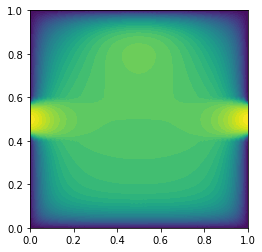

In [ ]:
# advance in time and post-process
time = 0.0

x_old = Function(X)
u_old, phi_old, p_old, tt_old = x_old.split()
u_old.rename('displacement', 'displacement')
p_old.rename('macro-pressure', 'macro-pressure')
tt_old.rename('micro-pressure', 'micro-pressure')
ufile = File('displacement.pvd')
pfile = File('mac-pressure.pvd')
tfile = File('mic-pressure.pvd')

ufile << (u_old, time)
pfile << (p_old, time)
tfile << (tt_old, time)

while time < T:
  time += dt
  t_n.t = time
  b = assemble(L)

  print('solving step {}'.format(time))
  Ainv.solve(x_old.vector(), b)
  u_old, phi_old, p_old, tt_old = x_old.split()
  u_old.rename('displacement', 'displacement')
  p_old.rename('macro-pressure', 'macro-pressure')
  tt_old.rename('micro-pressure', 'micro-pressure')
  ufile << (u_old, time)
  pfile << (p_old, time)
  tfile << (tt_old, time)

plot(p_old)

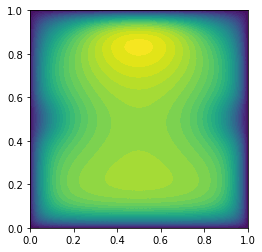

In [ ]:
plot(tt_old)

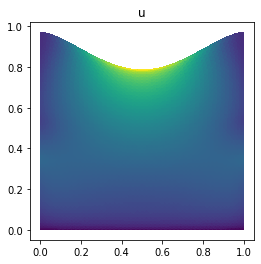

In [ ]:
plot(u_old, title='u', mode='displacement')